## Linear Regression

generally, regression's purpose is to characterize the relationship between inputs and outputs. 

they ofnen involve predicting a numerical value. 

#### Basic Elements of Linear Regression

linear regression consists of a few assumptions. one is that the relationship between dependant and independent variables is linear ie., y can be reperesented as a weighted sum of X, given some noise. and this noise follows gaussian distribution. 

data point, data instance, sample => features corresponding to one row

label, target => what we are trying to predict

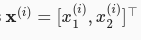

##### Linear Model

assume the regression problem is house price prediction. 

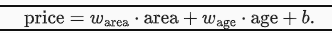

price could be calculated like this where w's are weights and b is the offset/intercept

in general, this is represented as 

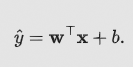

broadcasting is applied during summation if transpose is removed. 

##### Loss Function

the loss function quanifies the distance between real and predicted value of the target. it's usually a non negative number and smaller is better. the most popular loss function is mean squared error (MSE)

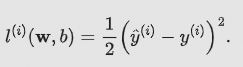

1/2 just makes notation simpler and gets cancelled out when derivative is taken

when we train the model, we find the parameters (weight and intercept) such that they minimize the loss across all training examples

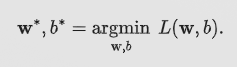

##### Analytic Solution

unlike other deep learning models, linear regression is simple enough to be solved analytically using a simple formula.

we take the derivative of loss with respect to w, and equating it to zero gives the best w (w*)

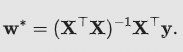

although this is good, we should not try to go for analytic solutions as they restrict us and not allow us to leverage other deep learning techniques

##### Minibatch Stochastic Gradient Descent

the key technique of optimizing nearly every deep learning model is iteratively reducing the error by updating the parameters in the direction that incrementally lowers the loss. this is called gradient descent

in the naive version of gradient descent we take the entire data, calculate the average loss by taking the derivative of the loss function and make a single update. this is extremely slow when we have large amounts of data. thus we settle for sampling a random minibatch of samples from the data to make each update. this is called minibatch stochastic gradient descent. 

we take a mini batch of size B, compute the gradient of average losses of the minibatch, multiply it with B/|n| where n is a predetermined positive value, get the new weights and biases and subtract them from the existing weights and biases to get the new values. 

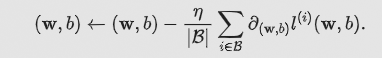

to summarize, 

- we initialize the values of model parameters at random
- iteratively sample random minibatches of data, update the parameters in the direction of negative gradient

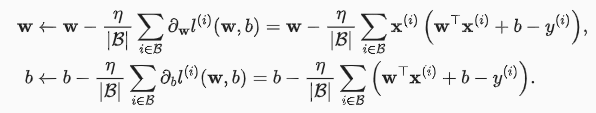

here, n is called learning rate. here n and B are the hyperparameters and the best values are chosen using hyperparameter tuning

linear regression assumes there's only one minimum in the entire domain. however other more complicated deep networks contain more than one minima. the more formidable task is to find parameters that will achieve low loss on data that we have not seen before, this is called generalization

##### Making Predictions with the Learned Model

predicting values is also called as inference. but in deep learning it's a misnomer. in statistics inference denotes estimating parameters based on a dataset

### Vectorization for Speed

when using mini batch sgd, it's better to process batches simulatenously as this leverages fast linalg libraries rather than writing for loops in vanilla python

In [5]:
%matplotlib inline
import math
import numpy as np
import time
import torch 
from d2l import torch as d2l

proving pytorch does stuff faster than vanilla python

In [6]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [10]:
class Timer:
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        self.tik = time.time()
    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        return sum(self.times)/len(self.times)
    def sum(self):
        return sum(self.times)
    def cumsum(self):
        return np.array(self.times).cumsum().tolist()

In [11]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
print(f"{timer.stop():.5f} sec")

0.08116 sec


In [12]:
timer.start()
d = a + b
print(f"{timer.stop():.5f} sec")

0.00246 sec


#### The Normal Distribution and Squared Loss

linear regression and the normal/gaussian distribution were both invented by the same person, Gauss. The probability density of a normal distribution with mean u and variance sigma^2, is given as 
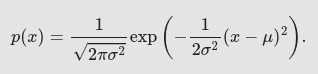

In [13]:
def normal(x, mu, sigma):
    p = 1/math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5/sigma**2 * (x - mu)**2)

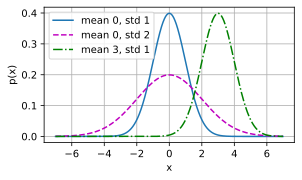

In [14]:
# Use numpy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

in linear regression, we assume that observations arise from noisy observations where the noise is normally distributed. 

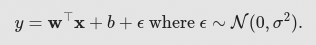

using this, we can say the likelihood of observing y, given x as

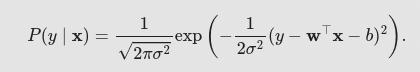

According to principle of maximum likelihood, the best parameters of w and b are those that maximize the likelihood of the entire dataset. 

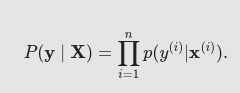

estimators chosen using maximum likelihood estimattion are called maximum likelihood estimators. to simplify multiplying large number of exponential functions, we maximize the logs instead and for historical reasons, we tend to minimize functions instead of maximizing them. so we take negative log-likelihood

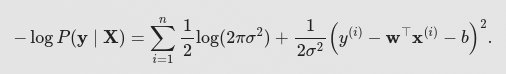

if we assume sigma to be a fixed constant, the entire first term can be ignored. the second term is similar to MSE ignoring the sigma^2. fortunately, it does not depend on sigma. it states that minimizing the mean squared error is equivalent to maximum likelihood estimation of a linear model under the assumption of additive gaussian noise

#### From Linear Regression to Deep Networks

##### Neural Network Diagram

conventionally, we do not consider input layer when we count the number of layers. we can think of linear regression as neural networks consisting of one single neuron aka as a single layer neural network

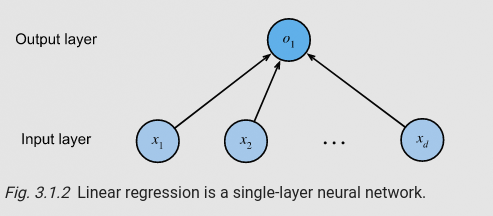

##### Biology

dendrites = input terminals,

nucleus = cpu

axon = output wire

axon terminals = output terminals

connections are enabled to other neurons from axon terminals using synapses
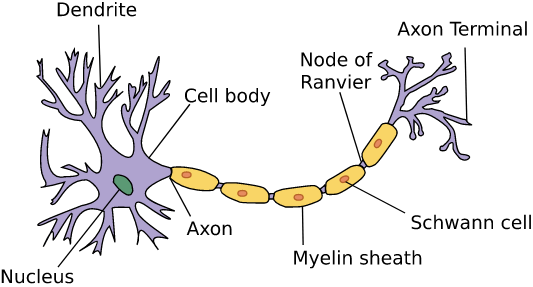

## Linear Regression Implementation from Scratch

In [16]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

#### Generating the Dataset

generating a 1000x2 dataset to allow us to visualize, also adding a normally distributed noise to it

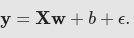

the true w and b for the dataset to be generated are [2, -3.4] and 4.2

In [20]:
def synthetic_data(w, b, num_examples):
    "Generate y = Xw + b + noise"
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [21]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [22]:
print(f"features: {features[0]}\nlabel: {labels[0]}")

features: tensor([-0.9251,  2.4406])
label: tensor([-5.9275])


we can observe the linear correlation between the two features using a scatter plot

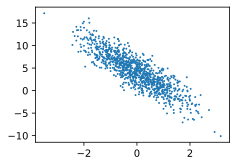

In [23]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

#### Reading the Dataset